Downloading and importing libraries.

In [ ]:
%%capture
#installing the required lib.
!pip install pafy youtube-dl moviepy

In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


And will set Numpy, Python, and Tensorflow seeds to get consistent results on every execution.

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

Download and Visualize the Data with its Labels. <br>
We will be using the <b>UCF50 – Action Recognition Dataset </b>, consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors. The Dataset contains:

50 Action Categories<br>
25 Groups of Videos per Action Category<br>
133 Average Videos per Action Category<br>
199 Average Number of Frames per Video<br>
320 Average Frames Width per Video<br>
240 Average Frames Height per Video<br>
26 Average Frames Per Seconds per Video<br>

In [ ]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

For visualization, we will pick all 50 categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written

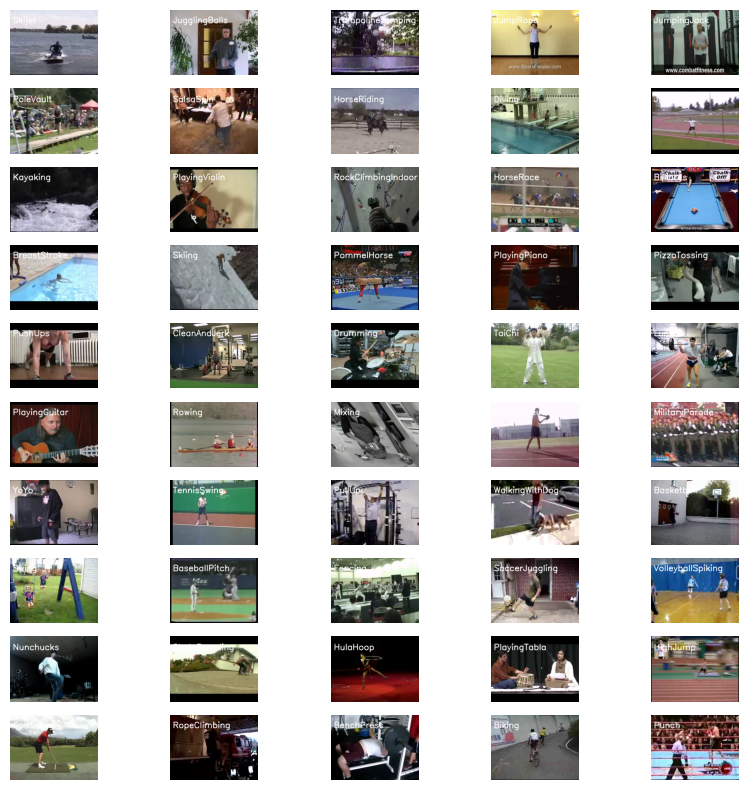

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (10, 10))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of random values within the available range.
# We are using the length of 'all_classes_names' to ensure we don't sample beyond the available elements.
random_range = random.sample(range(len(all_classes_names)), len(all_classes_names))

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    # Adjusted the subplot layout to accommodate all available classes.
    plt.subplot(math.ceil(len(all_classes_names) / 5), 5, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

Preprocess the Dataset<br>
 read the video files from the dataset and resize the frames of the videos to a fixed width and height<br>
 normalized the data by dividing it by 255 pixel value to make the range between [0-1] and to reduce computation <Br>
 number of frames per video = 20

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Basketball", "JumpingJack", "HorseRace", "HighJump", "GolfSwing","MilitaryParade"]

Extracting, Resizing & Normalizing Frames

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

creating dataset function to iterate through out the dataset

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
import os

DATASET_DIR = "UCF50"  # Update this if your dataset path is different
CLASSES_LIST = ["Basketball", "JumpingJack", "HorseRace", "HighJump", "GolfSwing", "MilitaryParade"]

missing_classes = []
available_classes = []

for class_name in CLASSES_LIST:
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.exists(class_path):
        available_classes.append(class_name)
    else:
        missing_classes.append(class_name)

print("✅ Available Classes:", available_classes)
print("❌ Missing Classes:", missing_classes)


✅ Available Classes: ['Basketball', 'JumpingJack', 'HorseRace', 'HighJump', 'GolfSwing', 'MilitaryParade']
❌ Missing Classes: []


In [ ]:
import os

dataset_path = "UCF50/SoccerJuggling"  # Adjust if necessary
print("Path exists:", os.path.exists(dataset_path))


Path exists: True


In [ ]:
dataset_dir = "UCF50"  # Root dataset directory

if os.path.exists(dataset_dir):
    print("Available classes:", os.listdir(dataset_dir))
else:
    print("Dataset directory not found!")


Available classes: ['TennisSwing', 'ThrowDiscus', 'Lunges', 'VolleyballSpiking', 'SalsaSpin', 'BaseballPitch', 'BenchPress', 'Biking', 'WalkingWithDog', 'Swing', 'SoccerJuggling', 'Billiards', 'PoleVault', 'Rowing', 'MilitaryParade', 'BreastStroke', 'Diving', 'JumpRope', 'JumpingJack', 'PlayingGuitar', 'CleanAndJerk', 'Kayaking', 'Punch', 'RockClimbingIndoor', 'PlayingTabla', 'HorseRace', 'Fencing', 'GolfSwing', 'TaiChi', 'PushUps', 'JugglingBalls', 'PommelHorse', 'Basketball', 'PullUps', 'JavelinThrow', 'YoYo', 'SkateBoarding', 'PizzaTossing', 'Nunchucks', 'HulaHoop', 'Skiing', 'Skijet', 'PlayingPiano', 'HorseRiding', 'TrampolineJumping', 'Drumming', 'RopeClimbing', 'HighJump', 'Mixing', 'PlayingViolin']


In [ ]:
# Extracting data files from the above Pre-defined classes using the above function.
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Basketball
Extracting Data of Class: JumpingJack
Extracting Data of Class: HorseRace
Extracting Data of Class: HighJump
Extracting Data of Class: GolfSwing
Extracting Data of Class: MilitaryParade


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

Spliting this dataset into train(70%) , valid(15%) and test(15%) datasets to evaluate further

In [ ]:
from sklearn.model_selection import train_test_split

# First, split into train (70%) and temp (30%) [temp will be further split into validation and test]
features_train, features_temp, labels_train, labels_temp = train_test_split(
    features, one_hot_encoded_labels, test_size=0.30, shuffle=True, random_state=seed_constant
)

# Now, split temp into validation (15%) and test (15%)
features_valid, features_test, labels_valid, labels_test = train_test_split(
    features_temp, labels_temp, test_size=0.50, shuffle=True, random_state=seed_constant
)

# Print dataset sizes
print(f"Train Set: {len(features_train)} samples")
print(f"Validation Set: {len(features_valid)} samples")
print(f"Test Set: {len(features_test)} samples")


Train Set: 545 samples
Validation Set: 117 samples
Test Set: 117 samples


Implement the ConvLSTM Approach

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        17,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,286 (196.43 KB)

 Trainable params: 50,286 (196.43 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


Checking model structure

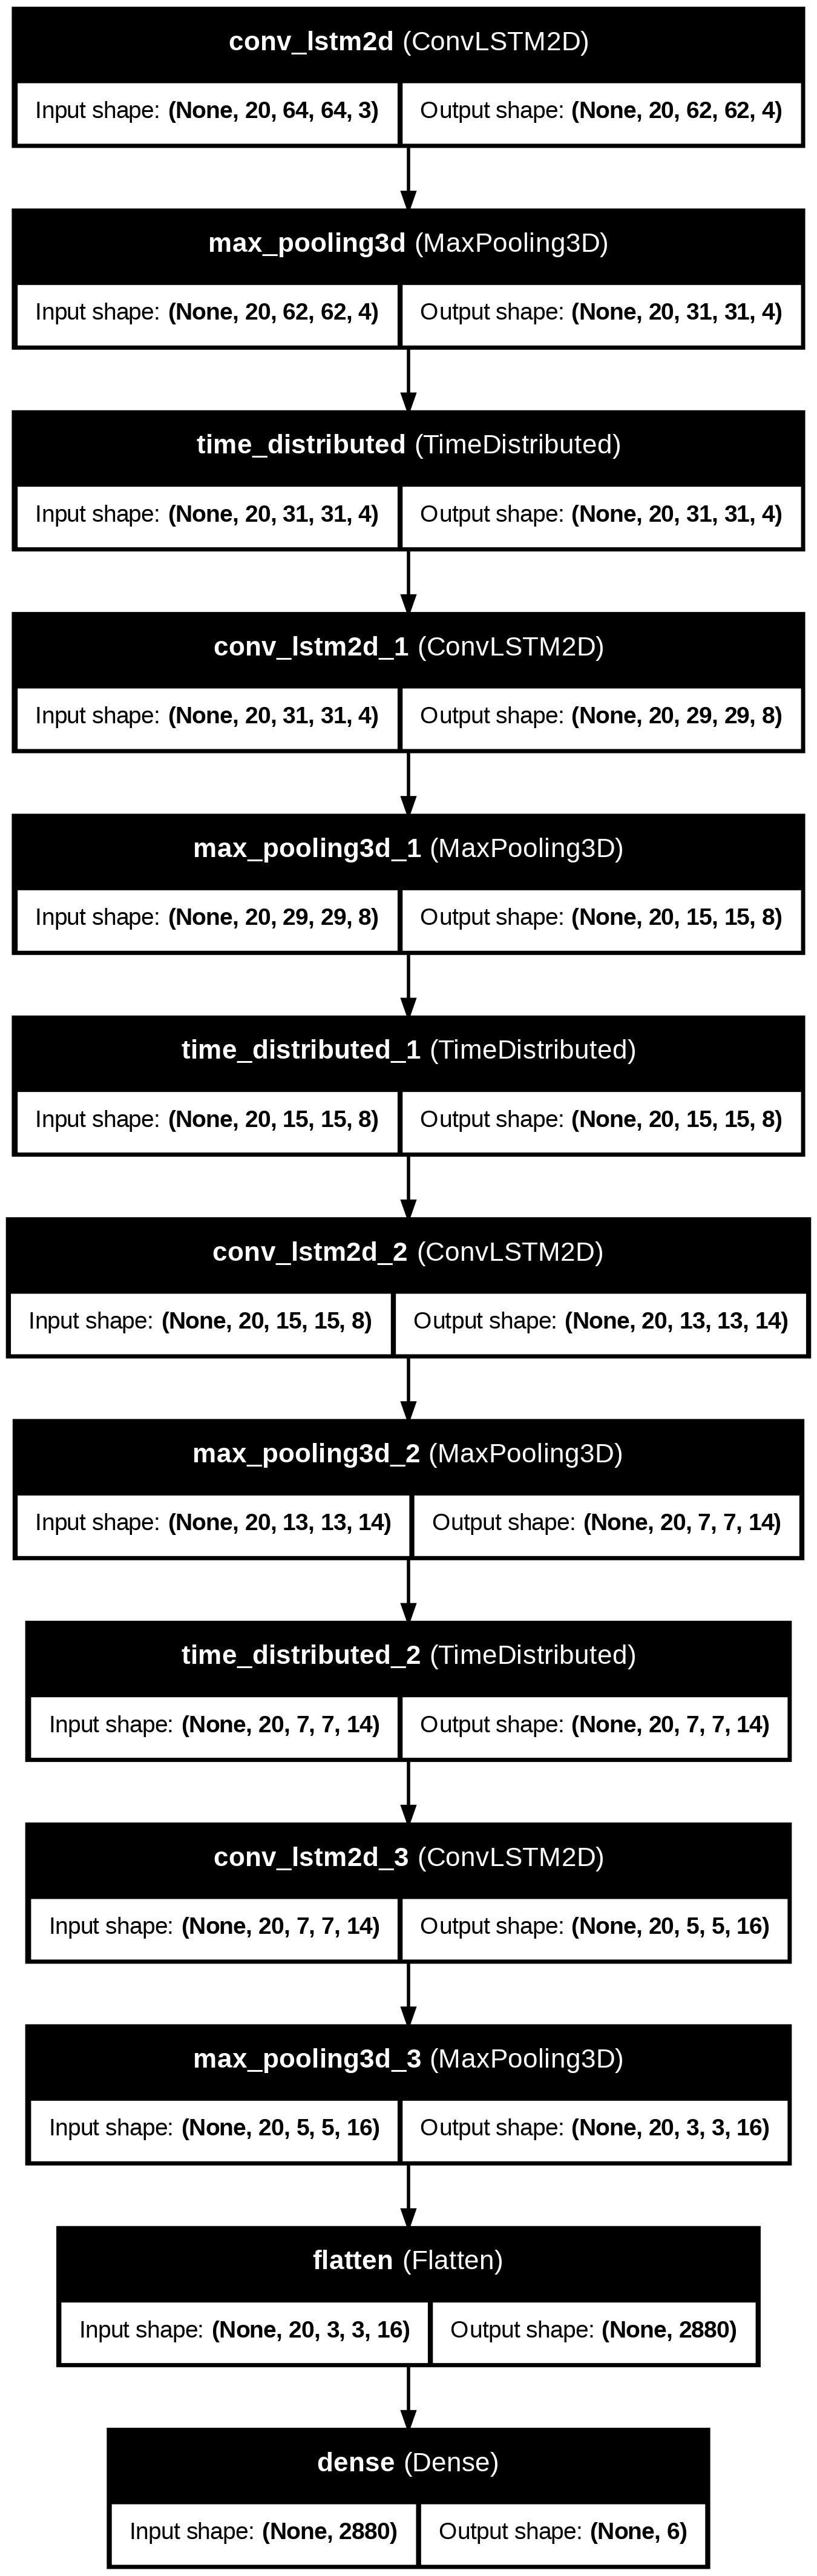

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer, and metrics
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Start training the model
convlstm_model_training_history = convlstm_model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=8,  # Consider increasing batch size if possible
    shuffle=True,
    validation_data=(features_valid, labels_valid),  # ✅ Pass validation set directly
    callbacks=[early_stopping_callback]
)


Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 113s 861ms/step - accuracy: 0.2346 - loss: 1.7526 - val_accuracy: 0.3504 - val_loss: 1.6074
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 0.4291 - loss: 1.4720 - val_accuracy: 0.5299 - val_loss: 1.1938
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5403 - loss: 1.1661 - val_accuracy: 0.6068 - val_loss: 1.0767
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6394 - loss: 1.0184 - val_accuracy: 0.6581 - val_loss: 1.0334
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7473 - loss: 0.7151 - val_accuracy: 0.6923 - val_loss: 0.9461
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.8206 - loss: 0.5476 - val_accuracy: 0.7179 - val_loss: 0.9130
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.8331 - loss: 0.4746 - val_accuracy: 0.7778 - val_loss: 0.7547
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.8988 - loss: 0.3415 - val_accuracy: 0.7692

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 922ms/step - accuracy: 0.8309 - loss: 0.9363


Learning loss and accuracy for the model and saving it for further use

In [ ]:
# Get the loss and accuracy from model evaluation.
model_evaluation_loss = model_evaluation_history[0]  # Always first value
model_evaluation_accuracy = model_evaluation_history[1] if len(model_evaluation_history) > 1 else None  # Check if accuracy exists

# Define the string date format.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss:.4f}'

if model_evaluation_accuracy is not None:
    model_file_name += f'___Accuracy_{model_evaluation_accuracy:.4f}'

model_file_name += '.keras'

# Save your Model.
convlstm_model.save(model_file_name)


In [ ]:
ls -lh


total 3.1G
-rw-r--r--  1 root root 663K Apr 29 21:00 convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras
-rw-r--r--  1 root root 354K Apr 29 20:53 convlstm_model_structure_plot.png
drwxr-xr-x  1 root root 4.0K Apr 28 13:35 sample_data/
drwxr-xr-x 52 root root 4.0K Oct  4  2010 UCF50/
-rw-r--r--  1 root root 3.1G Dec  1  2011 UCF50.rar


Plotting different graphs for further analysis.

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the given training and validation metrics in a graph.
    Args:
        model_training_history: A history object containing training and validation metrics.
        metric_name_1: Name of the first metric to be plotted (e.g., 'accuracy').
        metric_name_2: Name of the second metric to be plotted (e.g., 'val_accuracy').
        plot_name: Title of the graph.
    '''

    # Ensure the requested metrics exist in history to avoid errors.
    if metric_name_1 not in model_training_history.history or metric_name_2 not in model_training_history.history:
        print(f"Error: One or both metrics ({metric_name_1}, {metric_name_2}) not found in training history.")
        return

    # Get metric values from the history object.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get number of epochs.
    epochs = range(len(metric_value_1))

    # Plot the graph.
    plt.figure(figsize=(8, 5))  # Set figure size
    plt.plot(epochs, metric_value_1, 'b-', label=metric_name_1)  # 'b-' means blue line
    plt.plot(epochs, metric_value_2, 'r-', label=metric_name_2)  # 'r-' means red line

    # Add labels and title.
    plt.xlabel('Epochs')
    plt.ylabel(plot_name)
    plt.title(plot_name)
    plt.legend()

    # Add grid for better readability.
    plt.grid(True)

    # Show the plot.
    plt.show()


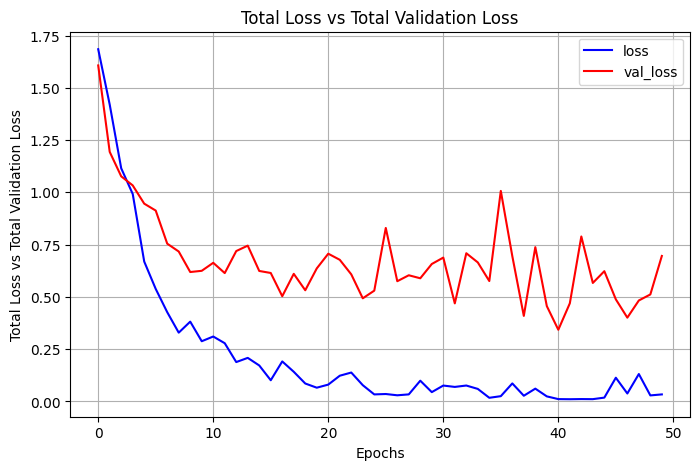

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

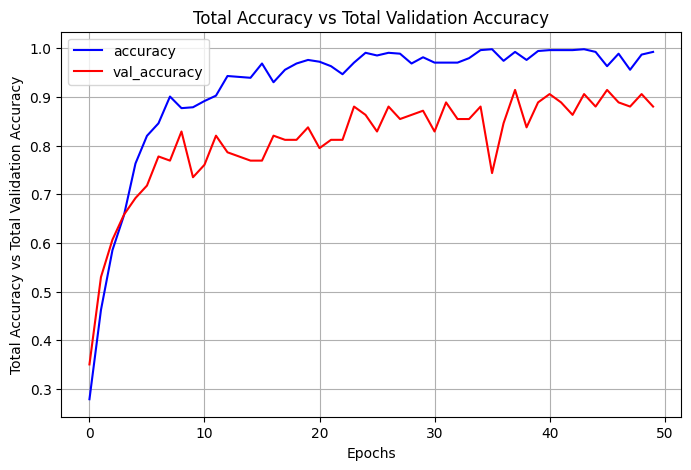

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


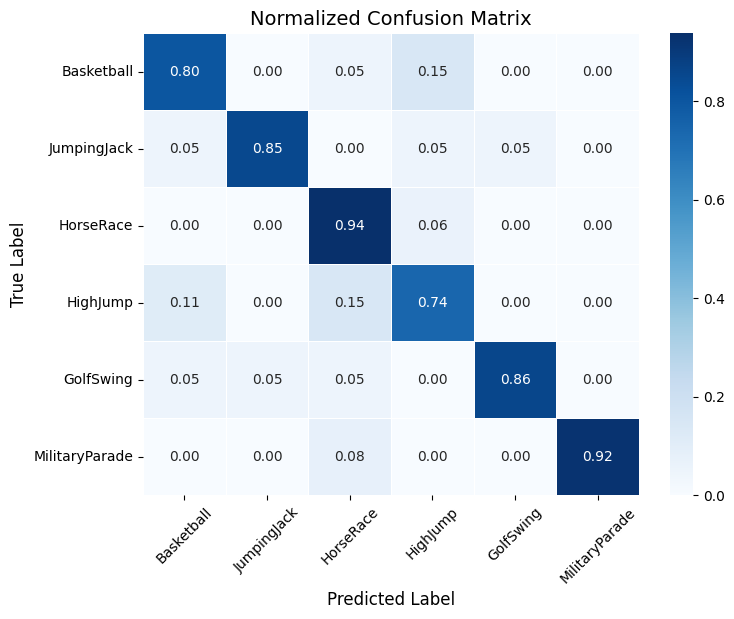

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict labels for the test set
y_pred = convlstm_model.predict(features_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class indices
y_true_classes = labels_test.argmax(axis=1)  # Convert one-hot to class indices

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix (optional: helps with imbalanced classes)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5,
            xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST, annot_kws={"size": 10})

# Formatting
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Normalized Confusion Matrix", fontsize=14)
plt.xticks(rotation=45)  # Rotate x labels for readability
plt.yticks(rotation=0)
plt.show()


Plotting training vs validation accuracy

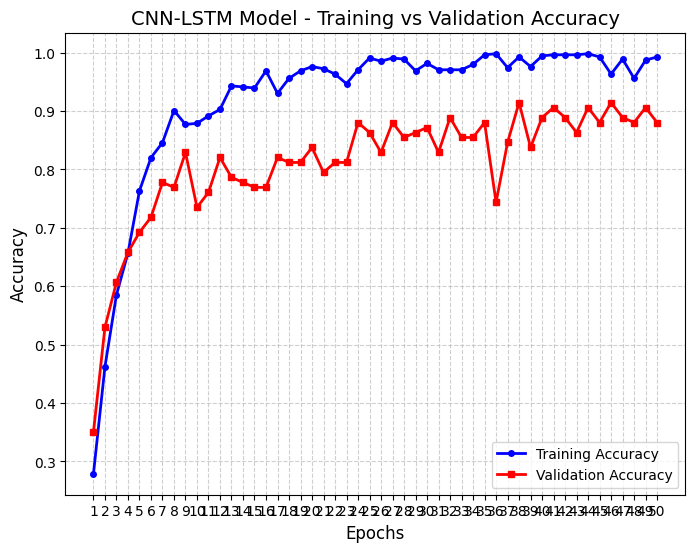

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training vs validation accuracy
def plot_training_vs_validation_accuracy(training_history, model_name):
    '''
    This function plots the training vs validation accuracy graph.
    Args:
        training_history: The history object from model.fit().
        model_name: Name of the model for labeling.
    '''
    # Extract training accuracy
    train_acc = training_history.history.get('accuracy', [])
    val_acc = training_history.history.get('val_accuracy', [])  # Handles missing val_accuracy

    # Get number of epochs
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(8, 6))

    # Plot Training Accuracy
    plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy', markersize=4, linewidth=2)

    # Plot Validation Accuracy (if available)
    if val_acc:
        plt.plot(epochs, val_acc, 'r-s', label='Validation Accuracy', markersize=4, linewidth=2)

    # Formatting
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.title(f"{model_name} - Training vs Validation Accuracy", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)  # Adds a light grid for better readability
    plt.xticks(epochs)  # Ensures all epochs are visible on x-axis
    plt.show()

# Plot for your CNN-LSTM model
plot_training_vs_validation_accuracy(convlstm_model_training_history, "CNN-LSTM Model")


In [ ]:
import os

# Define a directory where the model will be saved
SAVE_DIR = "saved_models"  # Change this to your desired path

# Ensure the directory exists; if not, create it
os.makedirs(SAVE_DIR, exist_ok=True)

# Print model summary and file name
print(convlstm_model)
print(f"Model will be saved as: {model_file_name}")

# Construct full file path
model_save_path = os.path.join(SAVE_DIR, model_file_name.replace('.h5', '.keras'))

# Save the model automatically to the directory
convlstm_model.save(model_save_path)

print(f"Model successfully saved at: {model_save_path}")


<Sequential name=sequential, built=True>
Model will be saved as: convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras
Model successfully saved at: saved_models/convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras


In [ ]:
print(convlstm_model)
print(model_file_name)
print(convlstm_model.save(model_file_name.replace('.h5', '.keras')))

<Sequential name=sequential, built=True>
convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras
None


In [ ]:
from google.colab import files

# Replace the filename with your actual model name
files.download("convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
print(os.listdir("/content/"))

!find /content/ -name "*.keras"


['.config', 'UCF50.rar', 'saved_models', 'convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras', 'UCF50', 'convlstm_model_structure_plot.png', 'sample_data']
/content/saved_models/convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras
/content/convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/"
!mkdir -p "/content/drive/My Drive/models/"


Mounted at /content/drive
 17226746647858344909406861532441.jpg
'2024 GE.gdoc'
'2024 GE.txt'
'AnishaKhandelwal-Data management 1.pdf'
'Anisha-Khandelwal-Mass-Rec2025 (1).pdf'
 Anisha-Khandelwal-Mass-Rec2025.pdf
'Anisha Khandelwal-Non-Tech Resume.pdf'
'Anisha Khandelwal - resume (1).pdf'
'Anisha Khandelwal - resume.pdf'
'Anisha Khandelwal update da.pdf'
'Anisha-Khandelwal-VITBhopal 3.pdf'
'Anisha-Khandelwal-VITBhopal- RESUME UPD (1).pdf'
'Anisha-Khandelwal-VITBhopal- RESUME UPD.pdf'
 Anisha-Khandelwal-VITB-Resume.pdf
'Colab Notebooks'
 Control_Robot_Using_Webpage.py
 Dataset
'Designing layouts and content writing.'
 dost
'Emotorad final ppt.pptx'
'Emotorad ppt.pptx'
 inbound5819208902267429647.pdf
 models
 places.gsheet
'Resume job'
'VN20240805_233353 (1).mp4'
 WIN_20250130_20_17_58_Pro.mp4


In [ ]:
!ls /content/
!find /content/ -name "*.keras"


convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras
convlstm_model_structure_plot.png
drive
sample_data
saved_models
UCF50
UCF50.rar
/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_03_12__16_36_05___Loss_0.818954348564148___Accuracy_0.7350427508354187.keras
/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_03_12__16_43_04___Loss_0.818954348564148___Accuracy_0.7350427508354187.keras
/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_03_12__17_40_29___Loss_0.5862807631492615___Accuracy_0.8418803215026855.keras
/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_04_19__17_04_42___Loss_0.5674___Accuracy_0.8803.keras
/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_04_22__12_41_43___Loss_0.4973___Accuracy_0.8803.keras
/content/saved_models/convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras
/content/convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Ac

In [ ]:
import shutil
import os

# Define correct filename
model_filename = "/content/saved_models/convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras"

# Find the model file
source_path = f"/content/{model_filename}"
if not os.path.exists(source_path):
    print("❌ Model file not found in /content/. Searching entire Colab...")
    model_files = !find /content/ -name "*.keras"
    if model_files:
        source_path = model_files[0]  # Use the first found model file
        print(f"✅ Found model at {source_path}")
    else:
        raise FileNotFoundError("❌ Model file not found anywhere in Colab!")

# Define destination
destination_dir = "/content/drive/My Drive/models/"
os.makedirs(destination_dir, exist_ok=True)

# Move the model file
shutil.move(source_path, os.path.join(destination_dir, os.path.basename(source_path)))

print("✅ Model successfully uploaded to Google Drive!")


❌ Model file not found in /content/. Searching entire Colab...
✅ Found model at /content/drive/MyDrive/models/convlstm_model___Date_Time_2025_03_12__16_36_05___Loss_0.818954348564148___Accuracy_0.7350427508354187.keras
✅ Model successfully uploaded to Google Drive!


loading the final model

In [ ]:
from tensorflow.keras.models import load_model
import os

# Correct path
convlstm_model_path = "/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_03_12__16_36_05___Loss_0.818954348564148___Accuracy_0.7350427508354187.keras"

# Verify the file exists
print("Model file exists:", os.path.exists(convlstm_model_path))
print("Is file:", os.path.isfile(convlstm_model_path))

# Load the model
try:
    model = load_model(convlstm_model_path)
    print("✅ Model loaded successfully")
except Exception as e:
    print("❌ Failed to load model:", e)


Model file exists: True
Is file: True
✅ Model loaded successfully


In [ ]:
#print("Model file exists:", os.path.exists(convlstm_model_path))


In [ ]:
'''import os

# Define the path to your model file
convlstm_model_path = "/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_03_12__16_36_05___Loss_0.818954348564148___Accuracy_0.7350427508354187.keras"  # Change this to your actual path

# Now check if the file exists
print("File exists:", os.path.exists(convlstm_model_path))
print("Is file:", os.path.isfile(convlstm_model_path))'''


File exists: True
Is file: True


In [ ]:
'''import glob

for file in glob.glob("/content/**/*.keras", recursive=True):
    print(file)'''


/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_03_12__16_36_05___Loss_0.818954348564148___Accuracy_0.7350427508354187.keras
/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_03_12__16_43_04___Loss_0.818954348564148___Accuracy_0.7350427508354187.keras
/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_03_12__17_40_29___Loss_0.5862807631492615___Accuracy_0.8418803215026855.keras
/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_04_19__17_04_42___Loss_0.5674___Accuracy_0.8803.keras
/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_04_22__12_41_43___Loss_0.4973___Accuracy_0.8803.keras
/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras
/content/saved_models/convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras


In [ ]:
'''convlstm_model_path = "/content/drive/MyDrive/models/convlstm_model___Date_Time_2025_03_12__16_36_05___Loss_0.818954348564148___Accuracy_0.7350427508354187.keras"
from tensorflow.keras.models import load_model

try:
    convlstm_model = load_model(convlstm_model_path)
    print("✅ ConvLSTM model successfully loaded!")
except Exception as e:
    print("❌ Error loading model:", e)'''


✅ ConvLSTM model successfully loaded!


In [ ]:
'''from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import PIL.Image
import io

# JavaScript code to capture webcam video
VIDEO_HTML = """
<video id="video" width="320" height="240" autoplay></video>
<button id="start">Start Recording</button>
<button id="stop">Stop Recording</button>
<script>
  var video = document.getElementById('video');
  var start = document.getElementById('start');
  var stop = document.getElementById('stop');
  var stream = null;
  var recorder = null;
  var chunks = [];

  async function getMedia() {
    stream = await navigator.mediaDevices.getUserMedia({ video: true });
    video.srcObject = stream;
  }

  async function startRecording() {
    chunks = [];
    recorder = new MediaRecorder(stream);
    recorder.ondataavailable = event => chunks.push(event.data);
    recorder.start();
  }

  function stopRecording() {
    recorder.stop();
    recorder.onstop = () => {
      var blob = new Blob(chunks, { type: 'video/webm' });
      var reader = new FileReader();
      reader.readAsDataURL(blob);
      reader.onloadend = function() {
        google.colab.kernel.invokeFunction('notebook.video_callback', [reader.result], {});
      };
    };
  }

  start.onclick = startRecording;
  stop.onclick = stopRecording;

  getMedia();
</script>
"""

from IPython.display import display, Javascript, HTML

display(HTML(VIDEO_HTML))

def video_callback(video_data):
    video_binary = b64decode(video_data.split(',')[1])
    with open('webcam_video.webm', 'wb') as f:
        f.write(video_binary)
    print("✅ Video saved as 'webcam_video.webm'")

# Register the function
from google.colab import output
output.register_callback('notebook.video_callback', video_callback)
'''

'from google.colab.output import eval_js\nfrom base64 import b64decode\nimport cv2\nimport numpy as np\nimport PIL.Image\nimport io\n\n# JavaScript code to capture webcam video\nVIDEO_HTML = """\n<video id="video" width="320" height="240" autoplay></video>\n<button id="start">Start Recording</button>\n<button id="stop">Stop Recording</button>\n<script>\n  var video = document.getElementById(\'video\');\n  var start = document.getElementById(\'start\');\n  var stop = document.getElementById(\'stop\');\n  var stream = null;\n  var recorder = null;\n  var chunks = [];\n\n  async function getMedia() {\n    stream = await navigator.mediaDevices.getUserMedia({ video: true });\n    video.srcObject = stream;\n  }\n\n  async function startRecording() {\n    chunks = [];\n    recorder = new MediaRecorder(stream);\n    recorder.ondataavailable = event => chunks.push(event.data);\n    recorder.start();\n  }\n\n  function stopRecording() {\n    recorder.stop();\n    recorder.onstop = () => {\n     

In [ ]:
#import os

#print("File exists:", os.path.exists("webcam_video.webm"))


File exists: False


In [ ]:
#!find /content -name "*.webm"


In [ ]:
#!ffmpeg -i webcam_video.webm -c:v libx264 webcam_video.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
'''import cv2
import numpy as np
from collections import deque

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function performs action recognition on a video using the trained model.
    Args:
        video_file_path:  Path of the input video.
        output_file_path: Path where the output video with predictions will be saved.
        SEQUENCE_LENGTH:  Number of frames to consider for action recognition.
    '''

    # Open video file
    video_reader = cv2.VideoCapture(video_file_path)

    # Get video properties
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video_reader.get(cv2.CAP_PROP_FPS))

    # Define Video Writer to save output
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'mp4v'), fps,
                                   (original_video_width, original_video_height))

    # Create a queue to store frames
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    while video_reader.isOpened():
        # Read a frame
        success, frame = video_reader.read()

        if not success:
            break

        # Resize and normalize frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0

        # Append frame to queue
        frames_queue.append(normalized_frame)

        # Perform prediction when enough frames are collected
        if len(frames_queue) == SEQUENCE_LENGTH:
            input_frames = np.expand_dims(frames_queue, axis=0)
            predicted_probs = LRCN_model.predict(input_frames)[0]
            predicted_label = np.argmax(predicted_probs)
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Display prediction on the video frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write the frame to output video
        video_writer.write(frame)

    # Release resources
    video_reader.release()
    video_writer.release()'''


In [ ]:
'''# Define input video file path
input_video_file_path = "webcam_video.webmy"
output_video_file_path = "webcam_video.mp4"

# Run prediction on the recorded webcam video
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video
from moviepy.editor import VideoFileClip
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()'''


 implement LRCN architecture

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,126 (285.65 KB)

 Trainable params: 73,126 (285.65 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


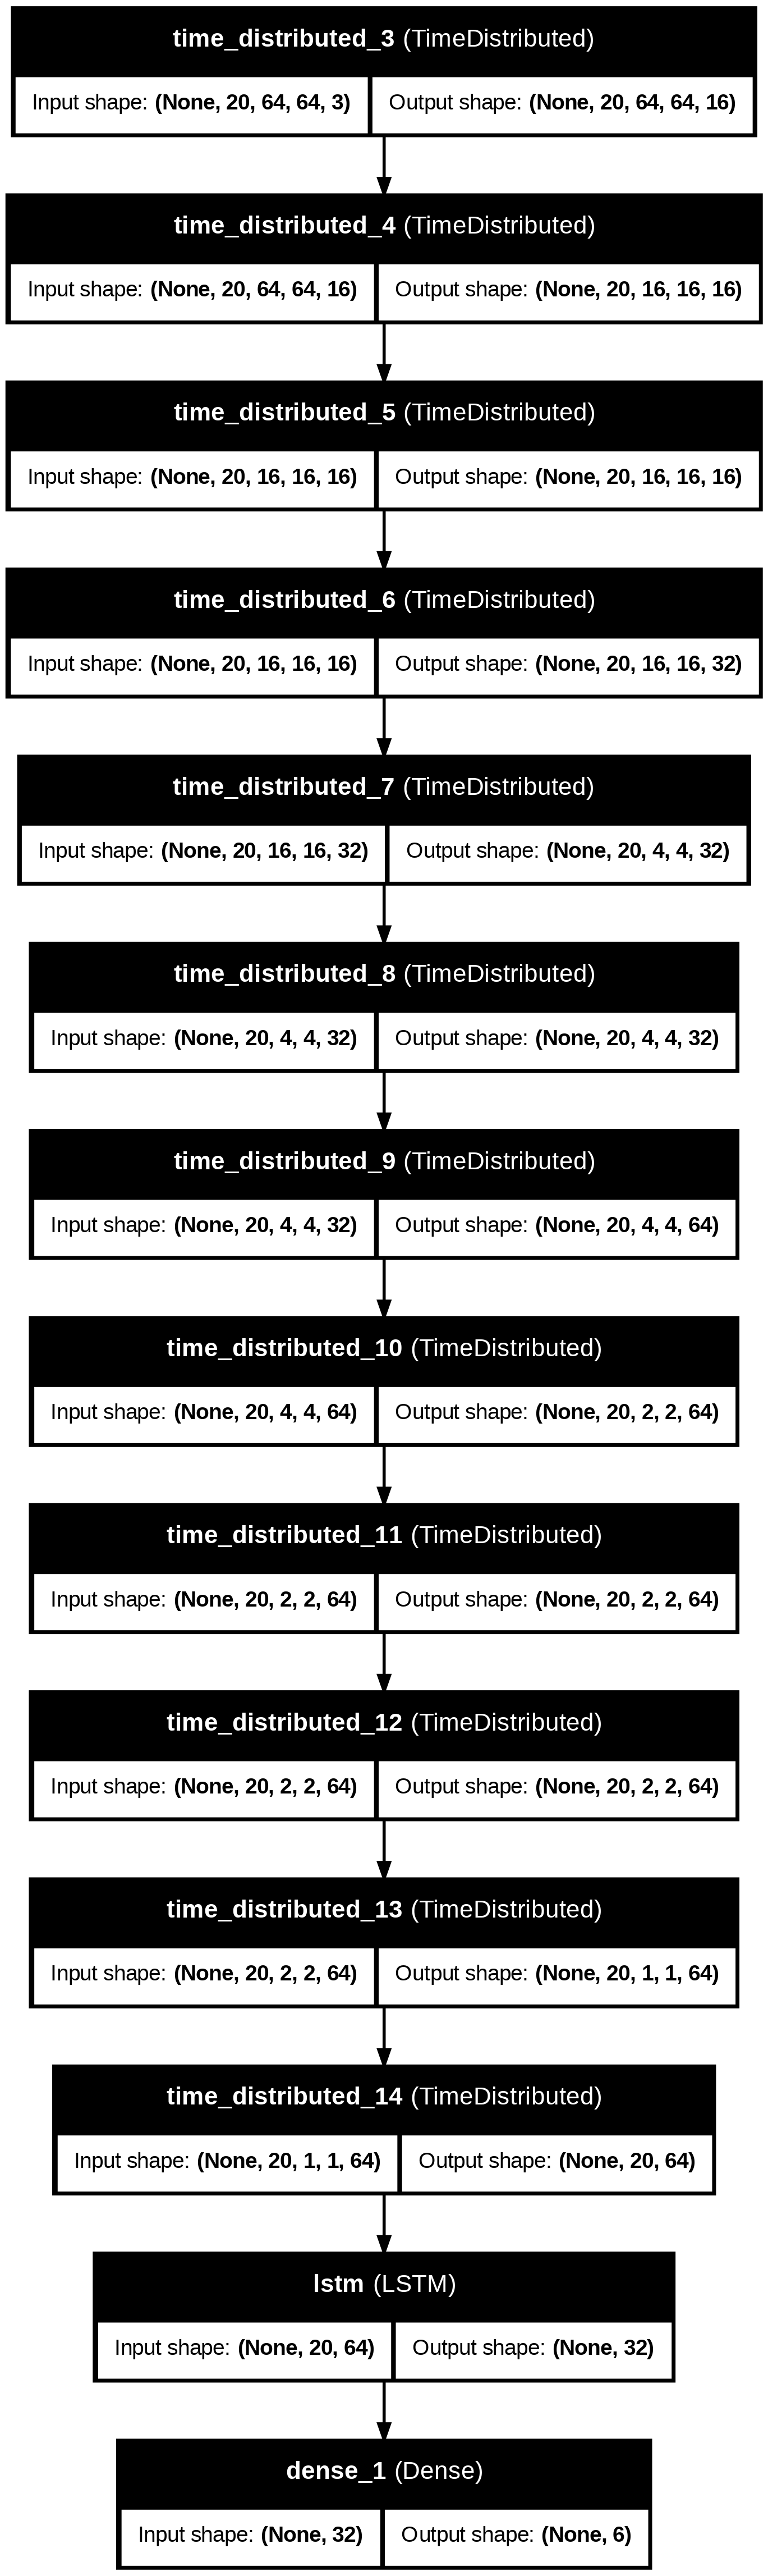

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer, and metrics.
LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(
    x=features_train,
    y=labels_train,
    epochs=70,
    batch_size=4,
    shuffle=True,
    validation_data=(features_valid, labels_valid),  # 🔹 Use explicit validation set
    callbacks=[early_stopping_callback]
)


Epoch 1/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - accuracy: 0.1906 - loss: 1.8121 - val_accuracy: 0.1795 - val_loss: 1.7641
Epoch 2/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.2585 - loss: 1.7211 - val_accuracy: 0.4359 - val_loss: 1.4352
Epoch 3/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.4101 - loss: 1.4541 - val_accuracy: 0.5128 - val_loss: 1.2428
Epoch 4/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.5724 - loss: 1.1745 - val_accuracy: 0.5983 - val_loss: 1.2053
Epoch 5/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6509 - loss: 0.9946 - val_accuracy: 0.6581 - val_loss: 0.9357
Epoch 6/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.7703 - loss: 0.7575 - val_accuracy: 0.7949 - val_loss: 0.7120
Epoch 7/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.7717 - loss: 0.6961 - val_accuracy: 0.7863 - val_loss: 0.6126
Epoch 8/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.8616 - loss: 0.4641 - val

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8996 - loss: 0.4358


In [ ]:
import datetime as dt  # Ensure this is imported

# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Format loss and accuracy to 4 decimal places for a clean filename.
formatted_loss = f"{model_evaluation_loss:.4f}"
formatted_accuracy = f"{model_evaluation_accuracy:.4f}"

# Get the current date and time in a formatted string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_string = dt.datetime.now().strftime(date_time_format)

# Define a useful name for the model in .keras format.
model_file_name = f"LRCN_model___Date_Time_{current_date_time_string}___Loss_{formatted_loss}___Accuracy_{formatted_accuracy}.keras"

# Save the model in the recommended format.
LRCN_model.save(model_file_name)

print(f"✅ Model successfully saved as: {model_file_name}")


✅ Model successfully saved as: LRCN_model___Date_Time_2025_04_29__21_21_25___Loss_0.4194___Accuracy_0.8974.keras


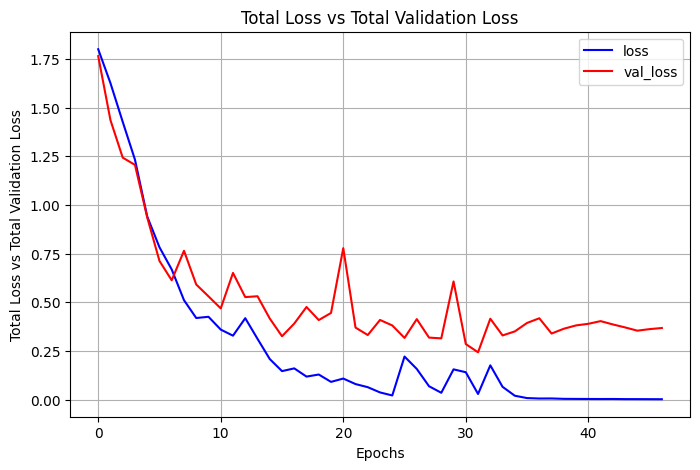

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


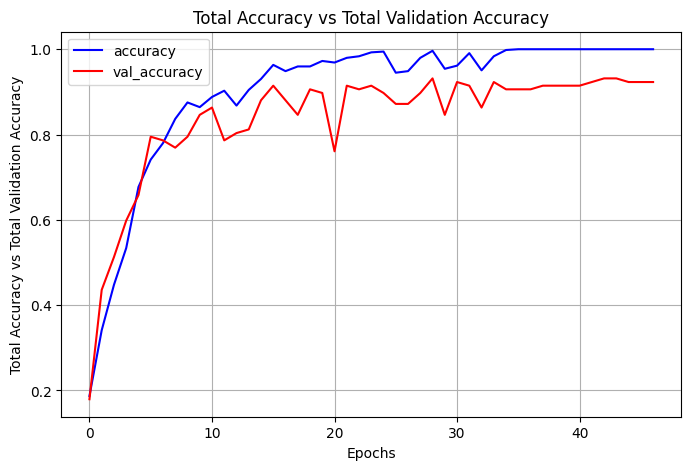

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 825ms/step


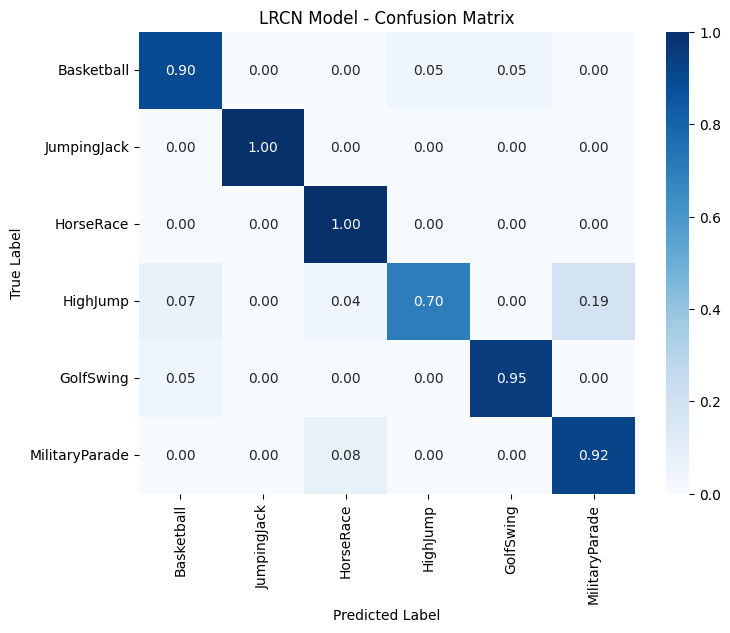

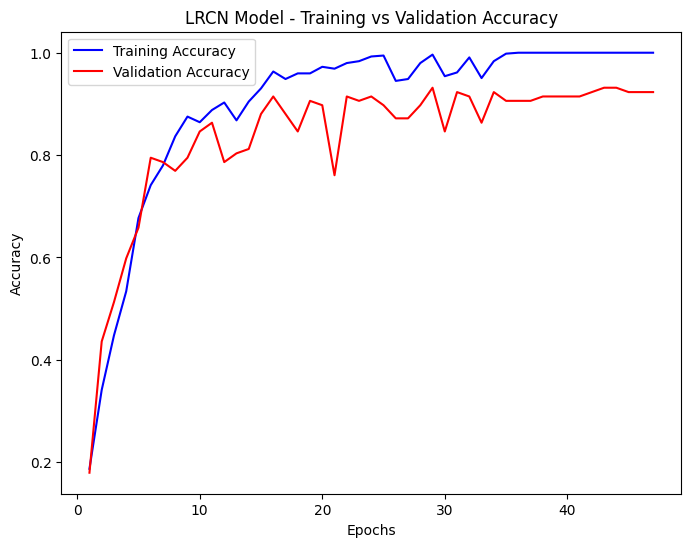

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_labels, model_name, normalize=False):
    """
    Function to plot a confusion matrix.
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_labels: List of class names
        model_name: Name of the model for labeling
        normalize: Whether to normalize the confusion matrix
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'g'

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt=fmt, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

# Function to plot training vs validation accuracy
def plot_training_vs_validation_accuracy(training_history, model_name):
    """
    Function to plot training vs validation accuracy.
    Args:
        training_history: The history object from model.fit().
        model_name: Name of the model for labeling.
    """
    train_acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Training vs Validation Accuracy")
    plt.legend()
    plt.show()

# Predict labels for the test set using LRCN
y_pred_lrcn = LRCN_model.predict(features_test)
y_pred_classes_lrcn = y_pred_lrcn.argmax(axis=1)
y_true_classes_lrcn = labels_test.argmax(axis=1)

# Plot confusion matrix for LRCN model
plot_confusion_matrix(y_true_classes_lrcn, y_pred_classes_lrcn, CLASSES_LIST, "LRCN Model", normalize=True)

# Plot training vs validation accuracy for LRCN model
plot_training_vs_validation_accuracy(LRCN_model_training_history, "LRCN Model")


In [ ]:
import os

# Round loss and accuracy for cleaner filenames
rounded_loss = round(model_evaluation_loss, 4)
rounded_accuracy = round(model_evaluation_accuracy, 4)

# Define a useful name for the model file
model_file_name_lrcn = f"LRCN_model___Date_Time_{current_date_time_string}___Loss_{rounded_loss}___Accuracy_{rounded_accuracy}.keras"

# (Optional) Define a save directory
save_dir = "/content/saved_models"
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Save the model
model_path = os.path.join(save_dir, model_file_name_lrcn)
LRCN_model.save(model_path)

print(f"✅ LRCN Model saved as: {model_path}")


✅ LRCN Model saved as: /content/saved_models/LRCN_model___Date_Time_2025_04_29__21_21_25___Loss_0.4194___Accuracy_0.8974.keras


In [ ]:
from google.colab import files

# Download the saved model
files.download(model_path)  # Use the full path

print("✅ LRCN Model successfully downloaded!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ LRCN Model successfully downloaded!


Model loading !

In [ ]:
model_path = "/content/saved_models/LRCN_model___Date_Time_2025_04_29__21_21_25___Loss_0.4194___Accuracy_0.8974.keras"
from tensorflow.keras.models import load_model
import os

# Define the model path (Ensure this path is correct)


# Check if the model file exists before loading
if os.path.exists(model_path):
    loaded_model = load_model(model_path)
    print("✅ Model Loaded Successfully!")
else:
    print("❌ Error: Model file not found! Please check the path.")


✅ Model Loaded Successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load the model saved as .keras
model = load_model("/content/saved_models/LRCN_model___Date_Time_2025_04_29__21_21_25___Loss_0.4194___Accuracy_0.8974.keras")

# Save the loaded model in .h5 format
model.save("/content/saved_models/LRCN_model_Converted.h5")



In [ ]:
from tensorflow.keras.models import load_model

try:
    # Try loading the model as an .h5 file
    model = load_model("/content/saved_models/LRCN_model_Converted.h5")
    print("Model loaded successfully as .h5")
except Exception as e:
    print("Error loading model:", e)


Model loaded successfully as .h5


In [ ]:
from google.colab import files

# Specify the path to your model file
model_path = '/content/saved_models/LRCN_model_Converted.h5'

# Download the file
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model

# ✅ Corrected paths
convlstm_model_path = "/content/saved_models/convlstm_model___Date_Time_2025_04_29__21_00_16___Loss_0.8078___Accuracy_0.8376.keras"
lrcn_model_path = "/content/saved_models/LRCN_model___Date_Time_2025_04_29__21_21_25___Loss_0.4194___Accuracy_0.8974.keras"

# ✅ Load models
loaded_convlstm_model = load_model(convlstm_model_path)
loaded_lrcn_model = load_model(lrcn_model_path)

# ✅ Get predictions
y_pred_convlstm = loaded_convlstm_model.predict(features_test)
y_pred_classes_convlstm = y_pred_convlstm.argmax(axis=1)

y_pred_lrcn = loaded_lrcn_model.predict(features_test)
y_pred_classes_lrcn = y_pred_lrcn.argmax(axis=1)

# ✅ Get actual labels
y_true_classes = labels_test.argmax(axis=1)

print("✅ Predictions from ConvLSTM and LRCN completed successfully!")


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 933ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 775ms/step
✅ Predictions from ConvLSTM and LRCN completed successfully!


plotting confusion matrices

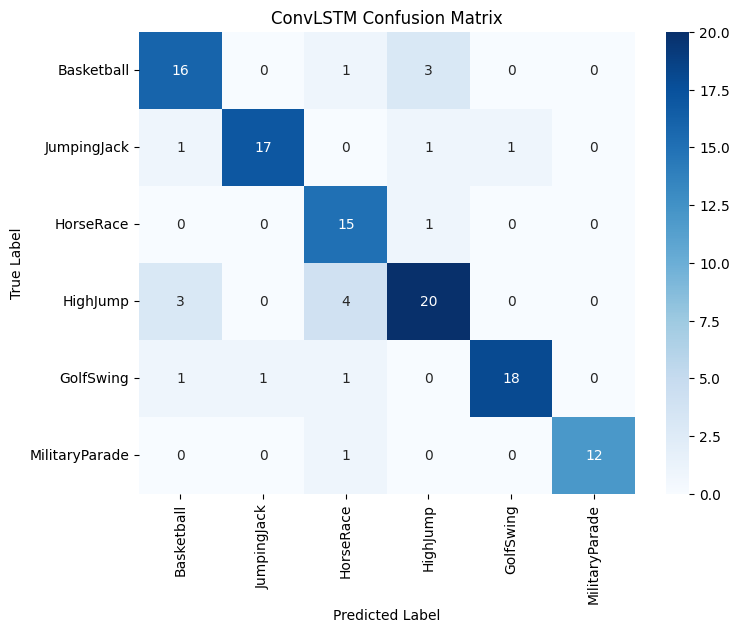

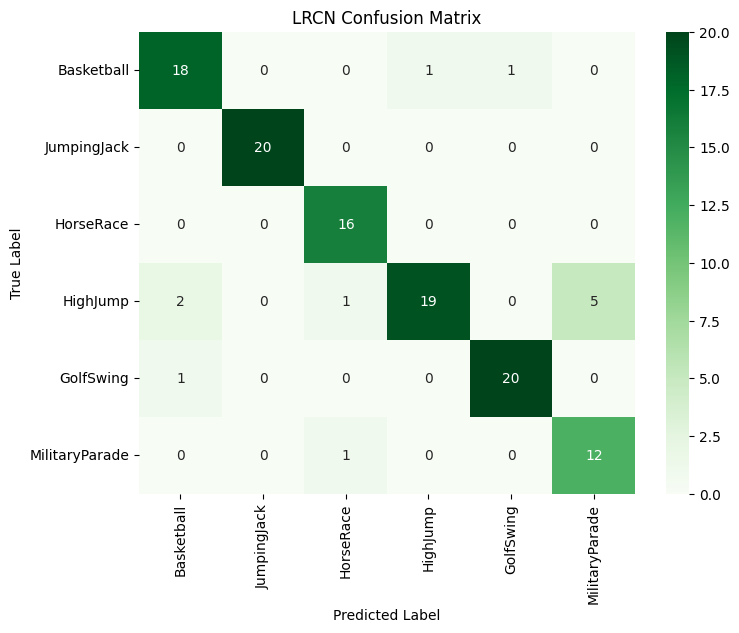

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
conf_matrix_convlstm = confusion_matrix(y_true_classes, y_pred_classes_convlstm)
conf_matrix_lrcn = confusion_matrix(y_true_classes, y_pred_classes_lrcn)

# Plot confusion matrix for ConvLSTM
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_convlstm, annot=True, cmap='Blues', fmt='g', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ConvLSTM Confusion Matrix")
plt.show()

# Plot confusion matrix for LRCN
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_lrcn, annot=True, cmap='Greens', fmt='g', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LRCN Confusion Matrix")
plt.show()


compute evaluation matrices

In [ ]:
from sklearn.metrics import classification_report

# Generate classification reports
report_convlstm = classification_report(y_true_classes, y_pred_classes_convlstm, target_names=CLASSES_LIST)
report_lrcn = classification_report(y_true_classes, y_pred_classes_lrcn, target_names=CLASSES_LIST)

print("🔹 ConvLSTM Model Performance:\n", report_convlstm)
print("\n🔹 LRCN Model Performance:\n", report_lrcn)


🔹 ConvLSTM Model Performance:
                 precision    recall  f1-score   support

    Basketball       0.76      0.80      0.78        20
   JumpingJack       0.94      0.85      0.89        20
     HorseRace       0.68      0.94      0.79        16
      HighJump       0.80      0.74      0.77        27
     GolfSwing       0.95      0.86      0.90        21
MilitaryParade       1.00      0.92      0.96        13

      accuracy                           0.84       117
     macro avg       0.86      0.85      0.85       117
  weighted avg       0.85      0.84      0.84       117


🔹 LRCN Model Performance:
                 precision    recall  f1-score   support

    Basketball       0.86      0.90      0.88        20
   JumpingJack       1.00      1.00      1.00        20
     HorseRace       0.89      1.00      0.94        16
      HighJump       0.95      0.70      0.81        27
     GolfSwing       0.95      0.95      0.95        21
MilitaryParade       0.71      0.92      

compare convolstm vs lrcn

In [ ]:
import numpy as np

# Extract loss & accuracy values from model evaluation
convlstm_loss, convlstm_accuracy = loaded_convlstm_model.evaluate(features_test, labels_test)
lrcn_loss, lrcn_accuracy = loaded_lrcn_model.evaluate(features_test, labels_test)

# Print a performance summary
print("\n📊 Model Performance Comparison:")
print(f"✅ ConvLSTM Accuracy: {convlstm_accuracy:.4f}, Loss: {convlstm_loss:.4f}")
print(f"✅ LRCN Accuracy: {lrcn_accuracy:.4f}, Loss: {lrcn_loss:.4f}")

# Determine the better model
if convlstm_accuracy > lrcn_accuracy:
    print("\n🏆 ConvLSTM performed better!")
elif lrcn_accuracy > convlstm_accuracy:
    print("\n🏆 LRCN performed better!")
else:
    print("\n🤝 Both models performed equally well.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.8309 - loss: 0.9363
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8996 - loss: 0.4358

📊 Model Performance Comparison:
✅ ConvLSTM Accuracy: 0.8376, Loss: 0.8078
✅ LRCN Accuracy: 0.8974, Loss: 0.4194

🏆 LRCN performed better!


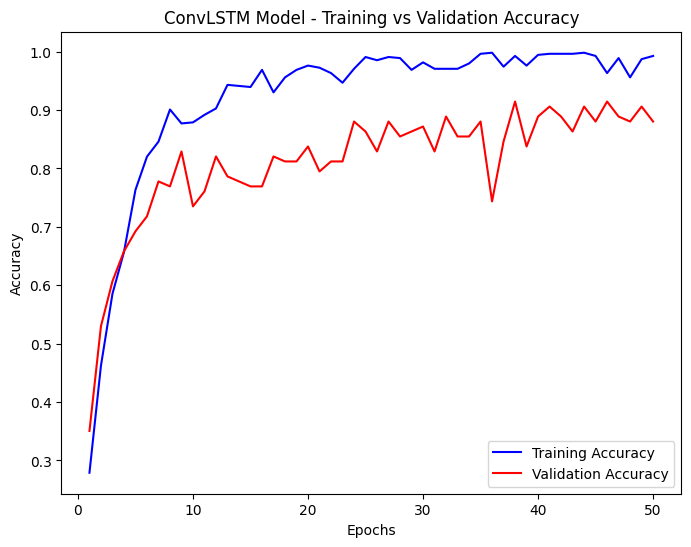

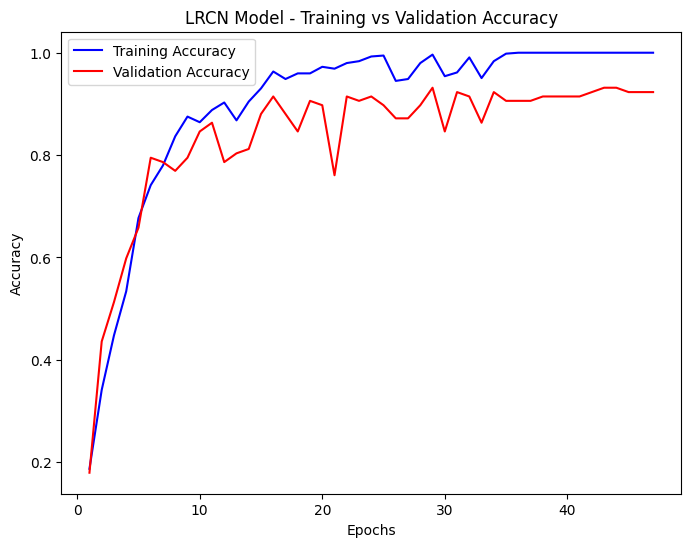

In [ ]:
# Function to plot accuracy comparison
def plot_training_vs_validation_accuracy(history, model_name):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(8,6))
    plt.plot(epochs, train_acc, 'b', label="Training Accuracy")
    plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Training vs Validation Accuracy")
    plt.legend()
    plt.show()

# Plot for ConvLSTM
plot_training_vs_validation_accuracy(convlstm_model_training_history, "ConvLSTM Model")

# Plot for LRCN
plot_training_vs_validation_accuracy(LRCN_model_training_history, "LRCN Model")


Building roc curves for the models

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Convert true labels to one-hot encoding
y_true_one_hot = label_binarize(y_true_classes, classes=np.arange(len(CLASSES_LIST)))

# Get softmax probabilities from models
y_pred_proba_convlstm = y_pred_convlstm  # Already softmax output
y_pred_proba_lrcn = y_pred_lrcn  # Already softmax output

n_classes = len(CLASSES_LIST)


In [ ]:
def plot_roc_curve(y_true, y_pred_proba, model_name):
    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {CLASSES_LIST[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid()
    plt.show()


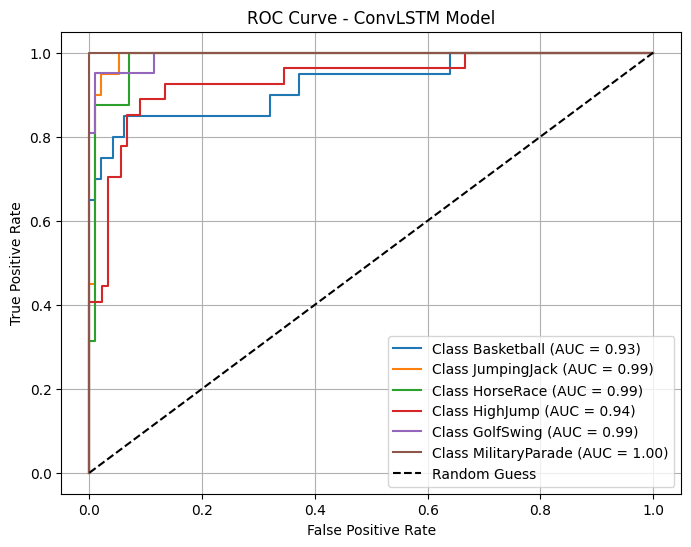

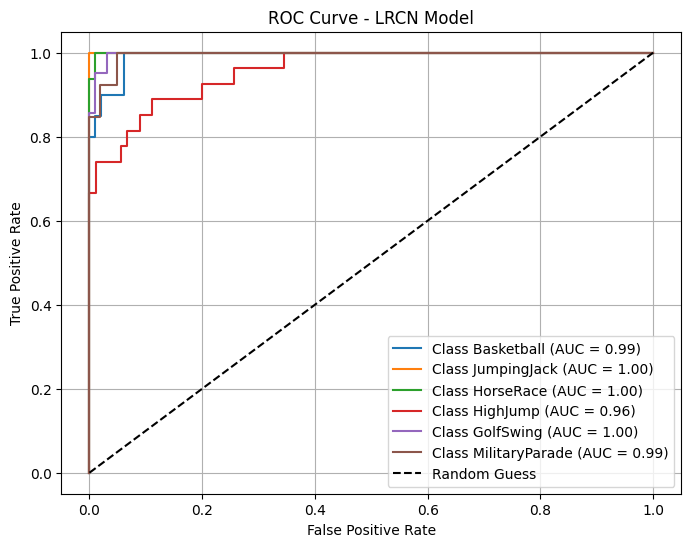

In [ ]:
# Plot ROC Curve for ConvLSTM
plot_roc_curve(y_true_one_hot, y_pred_proba_convlstm, "ConvLSTM Model")

# Plot ROC Curve for LRCN
plot_roc_curve(y_true_one_hot, y_pred_proba_lrcn, "LRCN Model")


🎥 **Test Clip 1**
✅ True Label: GolfSwing
🔮 Predicted Label: GolfSwing (Confidence: 0.9960)
--------------------------------------------------
Frame Min: 0.0 Frame Max: 1.0


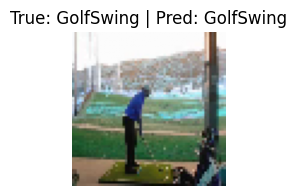

🎥 **Test Clip 2**
✅ True Label: GolfSwing
🔮 Predicted Label: GolfSwing (Confidence: 0.9958)
--------------------------------------------------
Frame Min: 0.0 Frame Max: 1.0


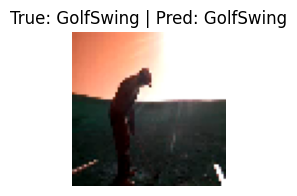

🎥 **Test Clip 3**
✅ True Label: Basketball
🔮 Predicted Label: Basketball (Confidence: 0.9880)
--------------------------------------------------
Frame Min: 0.0 Frame Max: 1.0


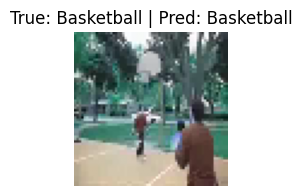

🎥 **Test Clip 4**
✅ True Label: GolfSwing
🔮 Predicted Label: Basketball (Confidence: 0.6385)
--------------------------------------------------
Frame Min: 0.0 Frame Max: 1.0


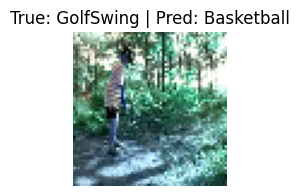

🎥 **Test Clip 5**
✅ True Label: HighJump
🔮 Predicted Label: HighJump (Confidence: 0.9961)
--------------------------------------------------
Frame Min: 0.0 Frame Max: 0.9333333333333333


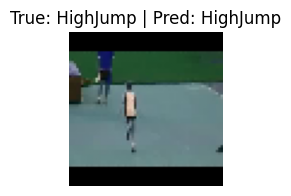

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of random samples to test
NUM_SAMPLES = 5

# Randomly select indices from test dataset
random_indices = np.random.choice(len(features_test), NUM_SAMPLES, replace=False)

# Loop through selected samples
for i, idx in enumerate(random_indices):
    # Extract the video clip
    test_clip = np.expand_dims(features_test[idx], axis=0)  # Add batch dimension
    test_clip = np.array(test_clip, dtype=np.float32)  # Ensure dtype matches model input

    # Get true label
    true_label_index = np.argmax(labels_test[idx]) if labels_test.ndim > 1 else labels_test[idx]
    true_label = CLASSES_LIST[true_label_index]

    # Make prediction
    predicted_probs = LRCN_model.predict(test_clip, verbose=0)[0]  # Disable progress bar
    predicted_label_index = np.argmax(predicted_probs)
    predicted_label = CLASSES_LIST[predicted_label_index]

    # Display results
    print(f"🎥 **Test Clip {i+1}**")
    print(f"✅ True Label: {true_label}")
    print(f"🔮 Predicted Label: {predicted_label} (Confidence: {predicted_probs[predicted_label_index]:.4f})")
    print("-" * 50)

    # Debugging: Check frame pixel values
    print("Frame Min:", features_test[idx][0].min(), "Frame Max:", features_test[idx][0].max())

    # Show first frame of the video clip
    frame = features_test[idx][0]
    if frame.max() > 1:
        frame = frame / 255.0  # Normalize if needed
    plt.figure(figsize=(2, 2))
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"True: {true_label} | Pred: {predicted_label}")
    plt.show()


downloading csv's for the dashboarding !

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files  # If using Colab
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# ✅ Save Confusion Matrices
pd.DataFrame(conf_matrix_lrcn).to_csv("lrcn_confusion_matrix.csv", index=False)
pd.DataFrame(conf_matrix_convlstm).to_csv("convlstm_confusion_matrix.csv", index=False)

# ✅ Save Training History (Loss & Accuracy per Epoch)
pd.DataFrame(LRCN_model_training_history.history).to_csv("lrcn_training_history.csv", index=False)
# Fix: Use 'convlstm_model_training_history' instead of 'ConvLSTM_model_training_history'
pd.DataFrame(convlstm_model_training_history.history).to_csv("convlstm_training_history.csv", index=False)

# ✅ Save Predictions (True Labels vs Predicted Labels)
lrcn_results = pd.DataFrame({"True_Label": y_true_classes, "Predicted_Label": y_pred_classes_lrcn})
lrcn_results.to_csv("lrcn_predictions.csv", index=False)

convlstm_results = pd.DataFrame({"True_Label": y_true_classes, "Predicted_Label": y_pred_classes_convlstm})
convlstm_results.to_csv("convlstm_predictions.csv", index=False)

# ✅ Calculate ROC Curve Data before saving
# Convert true labels to one-hot encoding
y_true_one_hot = label_binarize(y_true_classes, classes=np.arange(len(CLASSES_LIST)))

# Get softmax probabilities from models
y_pred_proba_convlstm = y_pred_convlstm  # Already softmax output
y_pred_proba_lrcn = y_pred_lrcn  # Already softmax output

n_classes = len(CLASSES_LIST)

# Calculate ROC curve data for LRCN
fpr_lrcn = dict()
tpr_lrcn = dict()
thresholds_lrcn = dict()
for i in range(n_classes):
    fpr_lrcn[i], tpr_lrcn[i], thresholds_lrcn[i] = roc_curve(y_true_one_hot[:, i], y_pred_proba_lrcn[:, i])

# Calculate ROC curve data for ConvLSTM
fpr_convlstm = dict()
tpr_convlstm = dict()
thresholds_convlstm = dict()
for i in range(n_classes):
    fpr_convlstm[i], tpr_convlstm[i], thresholds_convlstm[i] = roc_curve(y_true_one_hot[:, i], y_pred_proba_convlstm[:, i])


# ✅ Save ROC Curve Data
# Assuming you want to save data for one class (e.g., class 0)
class_index = 0  # Change this to the desired class index

pd.DataFrame({"FPR": fpr_lrcn[class_index], "TPR": tpr_lrcn[class_index], "Thresholds": thresholds_lrcn[class_index]}).to_csv("lrcn_roc_data.csv", index=False)
pd.DataFrame({"FPR": fpr_convlstm[class_index], "TPR": tpr_convlstm[class_index], "Thresholds": thresholds_convlstm[class_index]}).to_csv("convlstm_roc_data.csv", index=False)

# ✅ Download all files
file_list = [
    "lrcn_confusion_matrix.csv", "convlstm_confusion_matrix.csv",
    "lrcn_training_history.csv", "convlstm_training_history.csv",
    "lrcn_predictions.csv", "convlstm_predictions.csv",
    "lrcn_roc_data.csv", "convlstm_roc_data.csv"
]

for file_name in file_list:
    files.download(file_name)

print("✅ All CSV files have been saved and downloaded successfully!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ All CSV files have been saved and downloaded successfully!


In [ ]:
'''import cv2
import numpy as np
from collections import deque

def preprocess_video(video_path, SEQUENCE_LENGTH):
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    video_reader = cv2.VideoCapture(video_path)

    while video_reader.isOpened():
        success, frame = video_reader.read()
        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            break  # Stop after collecting required frames

    video_reader.release()
    return np.expand_dims(frames_queue, axis=0)

# Provide the path to an unseen video
unseen_video_path = "path_to_your_video.mp4"
processed_frames = preprocess_video(unseen_video_path, SEQUENCE_LENGTH)'''


In [ ]:
# Install & Update Dependencies
!pip install -U yt-dlp
!yt-dlp --rm-cache-dir
!apt install ffmpeg

# Import Required Libraries
import os
import yt_dlp
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from collections import deque

# Function to Download YouTube Video
def download_youtube_video(youtube_url, output_dir):
    """
    Downloads a YouTube video using yt-dlp with a fake User-Agent.

    Args:
        youtube_url (str): The URL of the YouTube video.
        output_dir (str): The directory where the video will be saved.

    Returns:
        str: The path of the downloaded video.
    """

    os.makedirs(output_dir, exist_ok=True)

    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]',  # Force MP4 format
        'outtmpl': f'{output_dir}/%(title)s.%(ext)s',  # Save as title.mp4
        'noplaylist': True,
        'merge_output_format': 'mp4',
        'quiet': False,
        'user_agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(youtube_url, download=True)
            video_filename = ydl.prepare_filename(info)

        # Ensure correct MP4 format
        video_path = video_filename.replace(".webm", ".mp4").replace(".mkv", ".mp4")

        if not os.path.exists(video_path):
            raise FileNotFoundError("❌ Download failed! No MP4 file found.")

        print(f"✅ Video downloaded successfully: {video_path}")
        return video_path

    except yt_dlp.utils.DownloadError as e:
        print(f"❌ Error downloading video: {str(e)}")
        return None

# Function to Preprocess Video for Model Input
def preprocess_video(video_path, sequence_length=20, image_size=(64, 64)):
    """
    Extracts frames from a video, resizes them, and normalizes them for model input.

    Args:
        video_path (str): Path to the video file.
        sequence_length (int): Number of frames to extract.
        image_size (tuple): (height, width) to resize frames.

    Returns:
        np.array: Processed frames ready for prediction.
    """

    frames = deque(maxlen=sequence_length)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"❌ Error: Unable to open video file {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // sequence_length, 1)

    for i in range(sequence_length):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)
        success, frame = cap.read()

        if not success:
            break  # Stop if no more frames

        frame = cv2.resize(frame, image_size)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    cap.release()

    if len(frames) < sequence_length:
        raise ValueError(f"❌ Not enough frames! Extracted {len(frames)}, expected {sequence_length}")

    return np.expand_dims(frames, axis=0)

# Function to Run Model Prediction
def predict_action(model, video_frames, class_list):
    """
    Predicts the action in a given video.

    Args:
        model (keras.Model): The trained LRCN model.
        video_frames (np.array): The preprocessed video frames.
        class_list (list): List of class names.

    Returns:
        str: Predicted action label.
    """

    predictions = model.predict(video_frames)[0]
    predicted_index = np.argmax(predictions)
    predicted_class = class_list[predicted_index]
    confidence = predictions[predicted_index]

    print(f"🎥 Predicted Action: {predicted_class} (Confidence: {confidence:.4f})")
    return predicted_class

# Run the Full Pipeline
test_videos_directory = "test_videos"
youtube_video_url = "https://www.youtube.com/watch?v=dQw4w9WgXcQ"  # Public video

# Step 1: Download YouTube Video
video_file_path = download_youtube_video(youtube_video_url, test_videos_directory)

# Step 2: Ensure the video exists
if video_file_path:
    print(f"✅ Video ready for processing: {video_file_path}")

    # Step 3: Preprocess Video
    processed_frames = preprocess_video(video_file_path)

    # Step 4: Load Trained Model
    model_path = "LRCN_model.keras"  # Update with your actual model path
    LRCN_model = load_model(model_path)
    print("✅ Model loaded successfully!")

    # Step 5: Define Class Labels (Update based on your model)
    CLASSES_LIST = ["Jumping", "Running", "Sitting", "Standing", "Walking"]

    # Step 6: Predict Action
    predicted_label = predict_action(LRCN_model, processed_frames, CLASSES_LIST)

else:
    print("❌ Video download failed!")


Removing cache dir /root/.cache/yt-dlp ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
[youtube] Extracting URL: https://www.youtube.com/watch?v=dQw4w9WgXcQ
[youtube] dQw4w9WgXcQ: Downloading webpage
[youtube] dQw4w9WgXcQ: Downloading tv client config
[youtube] dQw4w9WgXcQ: Downloading player b21600d5
[youtube] dQw4w9WgXcQ: Downloading tv player API JSON
[youtube] dQw4w9WgXcQ: Downloading ios player API JSON
[youtube] dQw4w9WgXcQ: Downloading m3u8 information
[info] dQw4w9WgXcQ: Downloading 1 format(s): 616+140
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 39
[download] Destination: test_videos/Rick Astley - Never Gonna Give You Up (Official Music Video).f616.mp4
[download] fragment not found; Skipping fragment 1 ...
[download] fragment not found; Skipping fragment 2 ...
[download] frag

ERROR: The downloaded file is empty


❌ Error downloading video: ERROR: The downloaded file is empty
❌ Video download failed!


In [ ]:
cap = cv2.VideoCapture("sample_video.mp4")


In [ ]:
model = load_model("LRCN_model_Converted.h5")


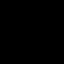

In [ ]:
!pip install opencv-python
from google.colab.patches import cv2_imshow
cv2_imshow(frame)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
frame_count = 0
while cap.isOpened() and frame_count < 200:
    ...
    frame_count += 1


In [ ]:
import cv2
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model

# Load your model
model = load_model("LRCN_model_Converted.h5")

# Class labels
classes = ['Basketball', 'JumpingJack', 'HorseRace', 'HighJump', 'GolfSwing', 'MilitaryParade']

# Frame sequence
sequence = deque(maxlen=20)

# Use a sample video file
cap = cv2.VideoCapture("sample_video.mp4")  # Add your test video here

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    resized_frame = cv2.resize(frame, (64, 64))
    normalized_frame = resized_frame / 255.0
    sequence.append(normalized_frame)

    if len(sequence) == 20:
        input_batch = np.expand_dims(np.array(sequence), axis=0)
        prediction = model.predict(input_batch)
        predicted_label = classes[np.argmax(prediction)]

        # Show prediction
        cv2.putText(frame, predicted_label, (10, 40), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Prediction Output", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
!pip install flask-ngrok
!pip install flask


In [ ]:
!pip install pyngrok flask
